In [6]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [7]:
BATCH_SIZE= 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
    

Found 2152 files belonging to 3 classes.


In [11]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [13]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 2 0 0 0 0 1 1 0]


2024-03-08 22:32:42.269961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-03-08 22:32:42.278050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


2024-03-08 22:39:21.324667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-03-08 22:39:21.326158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]
	 [[{{node Placeholder/_0}}]]


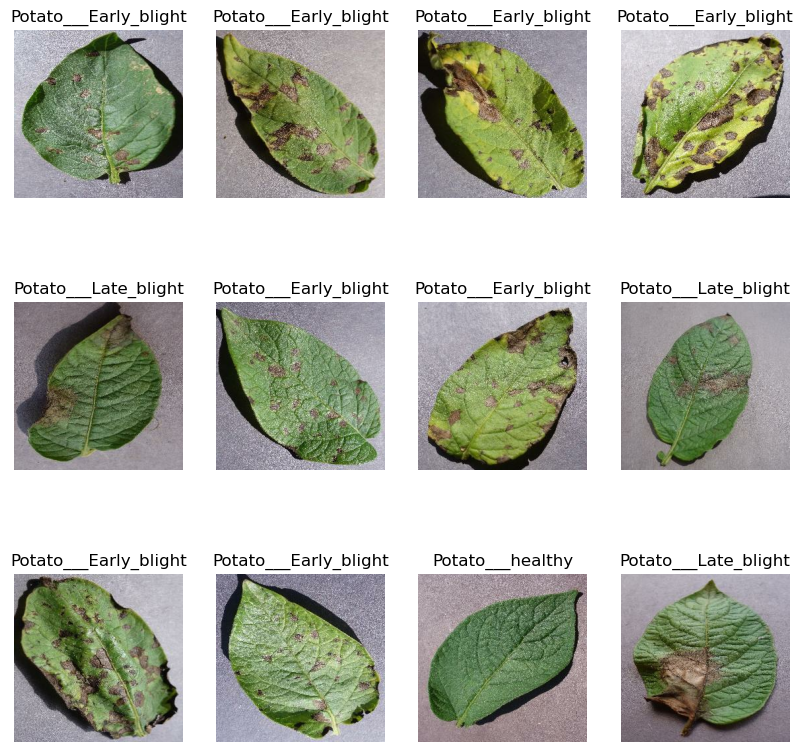

In [17]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [18]:
len(dataset)

68

In [19]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [20]:
train_ds = dataset.take(54)
len(train_ds)

54

In [21]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [22]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [23]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [27]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) ==1

    ds_size = len(ds)


    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split * ds_size)

    train_ds= ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
                        

In [28]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)



In [29]:
len(train_ds)

54

In [30]:
len(val_ds)

6

In [31]:
len(test_ds)

8

In [32]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [35]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [38]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training = True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
    
    

In [42]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50


2024-03-08 23:20:01.679125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-03-08 23:20:01.680018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


54/54 [==============================] - ETA: 0s - loss: 0.8677 - accuracy: 0.4873

2024-03-08 23:22:25.426743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-03-08 23:22:25.437182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


54/54 [==============================] - 149s 3s/step - loss: 0.8677 - accuracy: 0.4873 - val_loss: 0.7234 - val_accuracy: 0.6979
Epoch 2/50
54/54 [==============================] - 148s 3s/step - loss: 0.6437 - accuracy: 0.6829 - val_loss: 0.4820 - val_accuracy: 0.8229
Epoch 3/50
54/54 [==============================] - 146s 3s/step - loss: 0.4021 - accuracy: 0.8403 - val_loss: 0.4003 - val_accuracy: 0.8802
Epoch 4/50
54/54 [==============================] - 149s 3s/step - loss: 0.3618 - accuracy: 0.8432 - val_loss: 0.1916 - val_accuracy: 0.9323
Epoch 5/50
54/54 [==============================] - 121s 2s/step - loss: 0.2404 - accuracy: 0.9057 - val_loss: 0.1321 - val_accuracy: 0.9583
Epoch 6/50
54/54 [==============================] - 120s 2s/step - loss: 0.2298 - accuracy: 0.9132 - val_loss: 0.1397 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 122s 2s/step - loss: 0.1734 - accuracy: 0.9392 - val_loss: 0.1152 - val_accuracy: 0.9688
Epoch 8/50
54/54 [======

In [48]:
scores = model.evaluate(test_ds)

2024-03-09 04:56:41.008638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]
	 [[{{node Placeholder/_0}}]]
2024-03-09 04:56:41.009921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


8/8 [==============================] - 7s 406ms/step - loss: 0.0344 - accuracy: 0.9883


In [49]:
scores

[0.034373749047517776, 0.98828125]

In [50]:
history

In [51]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [52]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
len(history.history['loss'])

50

In [55]:
history.history['loss'][:5]

[0.8677029013633728,
 0.6437128782272339,
 0.4021497368812561,
 0.3617909848690033,
 0.24044077098369598]

In [56]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

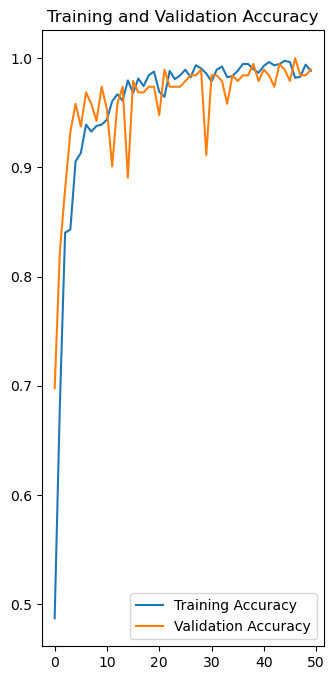

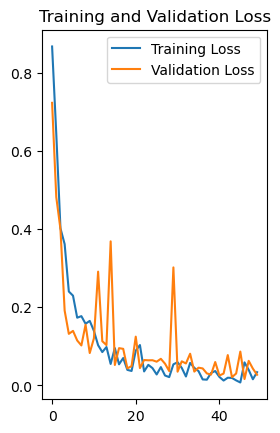

In [58]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(range (EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label= 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

2024-03-09 05:29:40.274272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-03-09 05:29:40.276234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 961ms/step
predicted label: Potato___Early_blight


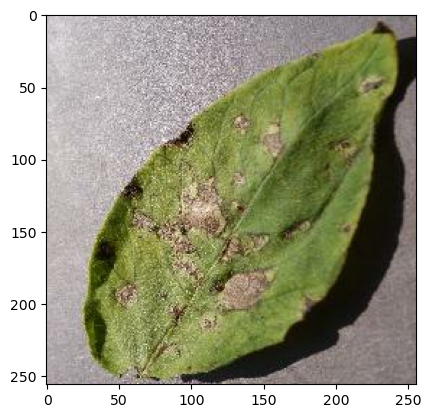

In [59]:
import numpy as np 
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])
    

In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


2024-03-09 05:40:36.159423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-03-09 05:40:36.160324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 76ms/step


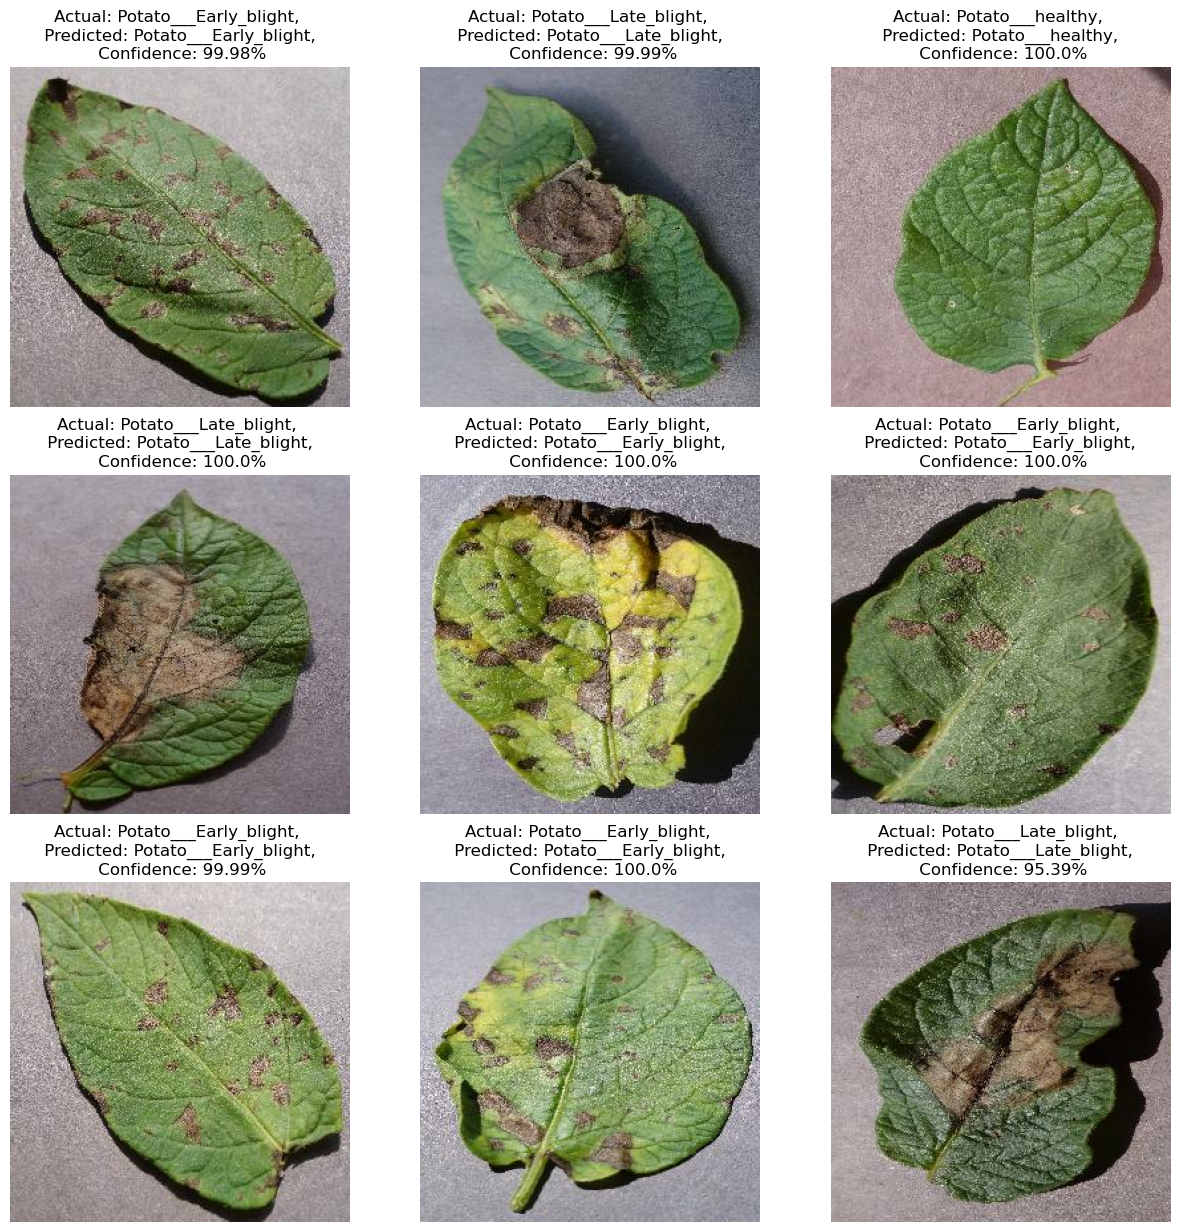

In [62]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")

        plt.axis("off")

In [64]:
import os
model_version= max([int(i) for i in os.listdir("models") + [0]]) +1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1/assets


INFO:tensorflow:Assets written to: models/1/assets


In [65]:
model.save("potatoes.h5")